# import libraries

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt

from pyaw.swarm import save_SW_EFIx_TCT16, save_SW_MAGx_HR_1B

# basic assignment of variables

In [2]:
analytical_start_time = '20160311T064700'
analytical_end_time = '20160311T064900'
# QA:: extend one window time (in this reproduction, the window time will be 20 seconds)
window_seconds = 20  # int
start_time = '20160311T064640'
end_time = '20160311T064920'
satellite = 'A'
sdir = Path("./data")
sfn_EFIA_TCT16 = Path("EFIA_TCT16_20160311T064640_20160311T064920.pkl")
sfn_MAGA_HR_1B = Path("MAGA_HR_1B_20160311T064640_20160311T064920.pkl")

# download data

In [3]:
save_SW_EFIx_TCT16(start_time, end_time, satellite, sdir,
                   sfn_EFIA_TCT16)
save_SW_MAGx_HR_1B(start_time, end_time, satellite, sdir,
                   sfn_MAGA_HR_1B)

data\EFIA_TCT16.pkl already exists, skip save.
data\MAGA_HR_1B.pkl already exists, skip save.


# read data

In [4]:
df_e = pd.read_pickle(Path(sdir) / Path(sfn_EFIA_TCT16))
df_b = pd.read_pickle(Path(sdir) / Path(sfn_MAGA_HR_1B))
extend_timestamps_e = df_e.index.values
timestamps_b = df_b.index.values

# magnetic field in NEC coordinate system

In [5]:
bn=[]
be=[]
bc=[]
for ndarray_ in df_b['B_NEC'].values:
    bn.append(ndarray_[0])
    be.append(ndarray_[1])
    bc.append(ndarray_[2])
bn = np.array(bn)
be = np.array(be)
bc = np.array(bc)

## plot

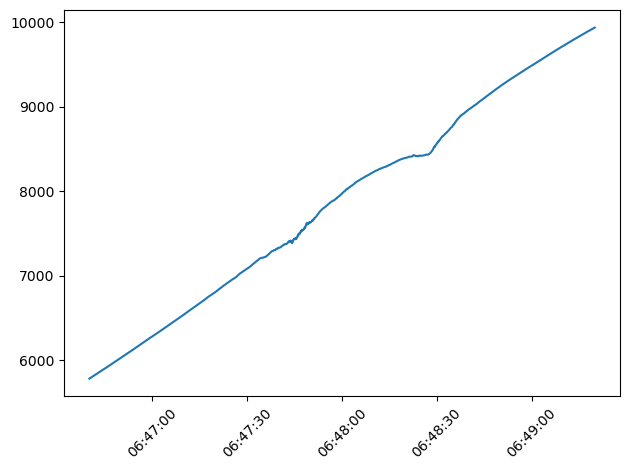

In [6]:
plt.plot(timestamps_b, bn)  # todo:: add latitude and so on information to the plot on x-axis
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

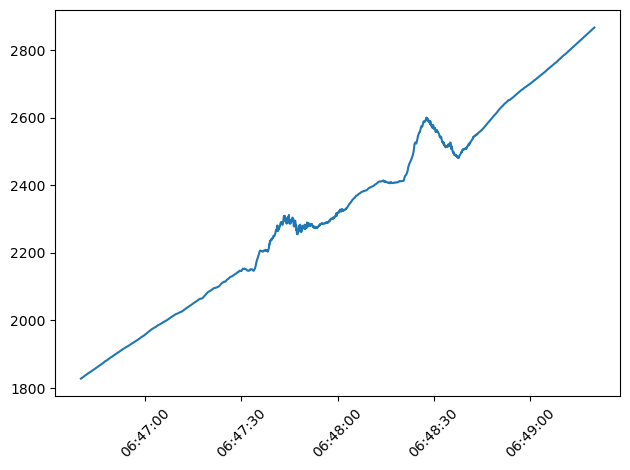

In [7]:
plt.plot(timestamps_b, be)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

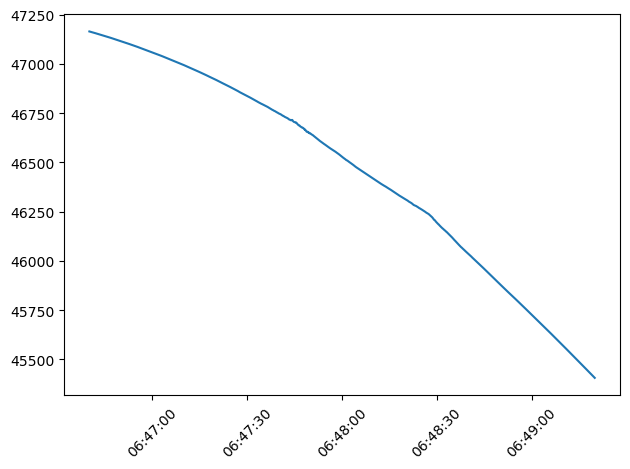

In [8]:
plt.plot(timestamps_b, bc)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# electric field in NEC coordinate system

## electric field in satellite-track coordinate system

In [9]:
# todo:: i.e. S/C coordinate system (in the later part, I will treat the satellite-track coordinate system as the S/C system) (no it will have a negative difference)?
extend_Ehx = df_e['Ehx'].values
extend_Ehy = df_e['Ehy'].values
extend_Ehz = df_e['Ehz'].values
extend_Evx = df_e['Evx'].values
extend_Evy = df_e['Evy'].values
extend_Evz = df_e['Evz'].values

### coordinate transformation from S/C coordinate system to NEC coordinate system

#### get rotation matrix

nec2sc, sc2nec (when deriving the rotation matrix, consider the rotation matrix from NEC to S/C and from S/C to NEC)

In [10]:
extend_VsatN = df_e['VsatN'].values
extend_VsatE = df_e['VsatE'].values

In [11]:
extend_theta = np.arctan(extend_VsatE / extend_VsatN)
extend_cos_theta = np.cos(extend_theta)
extend_sin_theta = np.sin(extend_theta)
# Stack components to construct the rotation matrices
extend_rotation_matrix = np.array([
    [extend_cos_theta, extend_sin_theta],
    [-extend_sin_theta, extend_cos_theta]
])
# Transpose axes to create a (3, 2, 2) array
extend_rotation_matrix_2d_nec2sc = np.transpose(extend_rotation_matrix, (2, 0, 1))
extend_rotation_matrix_2d_sc2nec = extend_rotation_matrix_2d_nec2sc.transpose(0, 2, 1)
del extend_rotation_matrix

In [12]:
def do_rotation(vectors1,vectors2,rotation_matrix):
    vectors12 = np.stack((vectors1,vectors2),axis=1)
    vectors12_rotated = np.einsum('nij,nj->ni', rotation_matrix, vectors12)
    return vectors12_rotated[:,0],vectors12_rotated[:,1]

#### preprocess before rotation

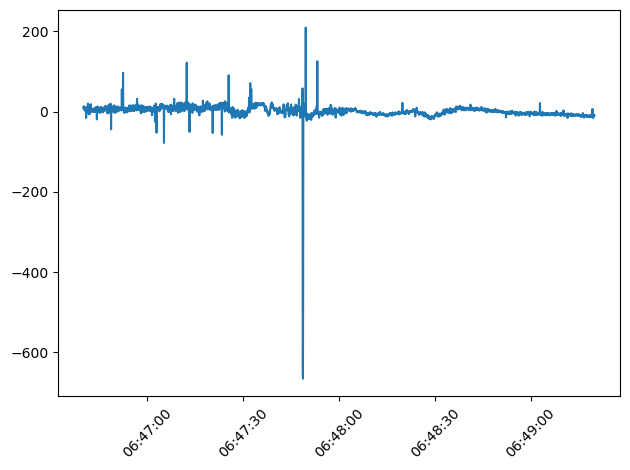

In [13]:
plt.plot(extend_timestamps_e, extend_Ehx)
plt.xticks(rotation=45)
plt.tight_layout()  # Ensures everything fits within the figure
plt.show()

In [14]:
np.std(extend_Ehx),np.mean(extend_Ehx),np.max(extend_Ehx),np.min(extend_Ehx)

(23.041916, 1.0366622, 209.64946, -665.1797)

In [15]:
def set_outliers_nan(array,std_times: float = 1.0, print_: bool = True):
    array_copy = array.copy()
    threshold = std_times * np.std(array_copy)
    bursts = np.abs(array_copy - np.mean(array_copy)) > threshold
    array_copy[bursts] = np.nan
    return array_copy

extend_Ehx_set_outliers_nan = set_outliers_nan(extend_Ehx)
extend_Ehy_set_outliers_nan = set_outliers_nan(extend_Ehy)

In [16]:
def get_array_interpolated(x,y):
    """
    :param x: ndarray consisting of np.datetime64. Specifically in this notebook the dtype of the array is np.datetime64[ns]
    :param y:
    :return:
    """
    y_copy = y
    # Mask for missing values
    mask = np.isnan(y_copy)
    # Interpolate
    y_copy[mask] = interpolate.interp1d(x[~mask].astype('int'), y_copy[~mask], kind='linear')(
        x[mask].astype('int'))
    return y_copy

In [17]:
extend_Ehx_set_outliers_nan_interpolated = get_array_interpolated(extend_timestamps_e, extend_Ehx_set_outliers_nan)
extend_Ehy_set_outliers_nan_interpolated = get_array_interpolated(extend_timestamps_e, extend_Ehy_set_outliers_nan)

#### do rotation

In [18]:
extend_Ehn,extend_Ehe = do_rotation(-extend_Ehx_set_outliers_nan_interpolated, -extend_Ehy_set_outliers_nan_interpolated, extend_rotation_matrix_2d_sc2nec)
# todo:: I add the negative sign to the x,y components of the electric field in the satellite-track coordinate system.

#### plot

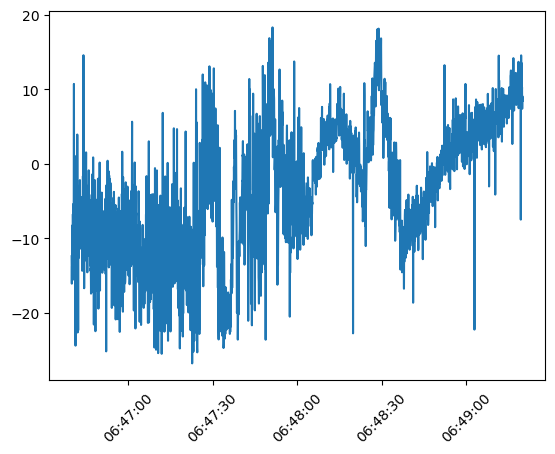

In [19]:
plt.plot(extend_timestamps_e, extend_Ehn)
plt.xticks(rotation=45)
plt.show()

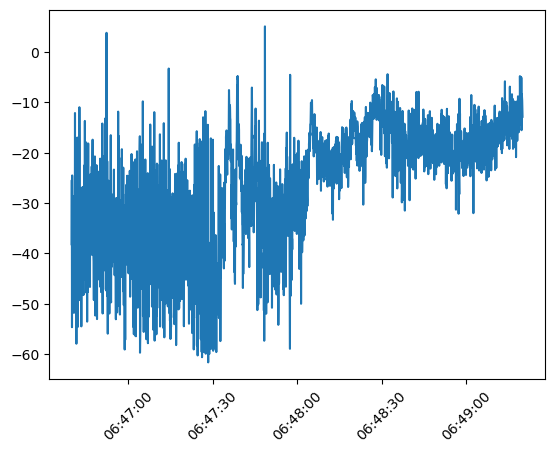

In [20]:
plt.plot(extend_timestamps_e, extend_Ehe)
plt.xticks(rotation=45)
plt.show()

# to verify the correlation between the satellite-track coordinate system and the S/C coordinate system

## IGRF13

NEC coordinate system

In [21]:
extend_latitudes = df_e['Latitude'].values
extend_longitudes = df_e['Longitude'].values
extend_radiuses = df_e['Radius'] / 1e3  # km

In [22]:
from igrf13 import igrf_utils
# from importlib import reload
# reload(igrf_utils)

extend_igrf_bn,extend_igrf_be,extend_igrf_bc = igrf_utils.get_igrf13_b_nec(extend_timestamps_e, extend_latitudes, extend_longitudes, extend_radiuses, igrf13shc_path="../igrf13/IGRF13.shc")

the whole loop takes time: 7.040594100952148s


### do rotation

from NEC coordinate system to S/C coordinate system

In [23]:
extend_igrf_b_sc_x,extend_igrf_b_sc_y = do_rotation(extend_igrf_bn, extend_igrf_be, extend_rotation_matrix_2d_nec2sc)

### compare IGRF magnetic field in S/C coordinate system with the magnetic field in the satellite-track coordinate system

In [24]:
extend_Bx = df_e['Bx'].values
extend_By = df_e['By'].values
extend_Bz = df_e['Bz'].values

In [25]:
extend_igrf_b_sc_x,extend_Bx

(array([5488.84597893, 5490.36120071, 5491.89705865, ..., 9822.42766948,
        9824.24009966, 9826.02530818]),
 array([-5522.3447, -5523.882 , -5525.445 , ..., -9703.592 , -9704.914 ,
        -9706.217 ], dtype=float32))

In [26]:
extend_igrf_b_sc_y,extend_By

(array([2402.89668432, 2403.29288557, 2403.69322004, ..., 3269.95250741,
        3270.22039535, 3270.48448059]),
 array([-2376.3591, -2376.8003, -2377.2485, ..., -3364.922 , -3365.4243,
        -3365.9182], dtype=float32))

In [27]:
np.array(extend_igrf_bc),extend_Bz

(array([47135.03779735, 47134.75750318, 47134.47364147, ...,
        45397.81913387, 45396.67775593, 45395.55296498]),
 array([47170.96 , 47170.67 , 47170.383, ..., 45423.27 , 45422.24 ,
        45421.223], dtype=float32))

### compare the Bx,By,Bz of EFIx_TCT16 download from VirES with EFIx_TCT16 download from ESA Swarm http database

In [29]:
import cdflib

fp = "./data/SW_EXPT_EFIA_TCT16_20160311T000000_20160311T065505_0302.cdf"

cdf_file = cdflib.CDF(fp)
info = cdf_file.cdf_info()

In [30]:
cdf_file.varattsget('Bx')

{'FIELDNAM': 'Bx',
 'CATDESC': 'Geomagnetic field x component in satellite-track coordinates, derived from the 1 Hz product.',
 'Type': 'CDF_FLOAT',
 'UNITS': 'nT',
 'VAR_TYPE': 'data',
 'DEPEND_0': 'Time',
 'DISPLAY_TYPE': 'time_series',
 'LABLAXIS': 'Bx',
 'VALIDMIN': -65000.0,
 'VALIDMAX': 65000.0}

In [31]:
Bx_local = cdf_file.varget('Bx')
timestamps_local = cdf_file.varget('Timestamp')

In [32]:
import numpy as np

# Create a numpy datetime object for Year 0, January 1, and the unit is millisecond
ad0_reference = np.datetime64('0000-01-01', 'ms')

# Convert the 'Timestamp' to datetime by adding the milliseconds since the epoch_reference
# Assuming 'Timestamp' is in milliseconds
timestamps_local = ad0_reference + np.array(timestamps_local, dtype='timedelta64[ms]')

# Print the first few datetime values
print(timestamps_local[:5])

['2016-03-11T00:00:00.006' '2016-03-11T00:00:00.068'
 '2016-03-11T00:00:00.131' '2016-03-11T00:00:00.193'
 '2016-03-11T00:00:00.256']


In [33]:
mask = np.where(timestamps_local > np.datetime64('2016-03-11T06:47:00'))
Bx_local = Bx_local[mask]
Bx_local

array([ -6025.4023,  -6026.9688,  -6028.56  , ..., -18554.49  ,
       -18555.754 , -18556.998 ], dtype=float32)

### conclusion

(x,y,z) in satellite-track coordinate system, in S/C coordinate system, it will be (-x,-y,z)

In [34]:
# todo:: according to the doc of tct16, the x axis of the satellite-track coordinate system is in the direction of the satellite velocity that is same to the x axis of the S/C coordinate system??? so why there is a negative sign difference between the x and y components of the magnetic field in the satellite-track coordinate system and the S/C coordinate system?

# measurement E north and measurement B east

## original E and B

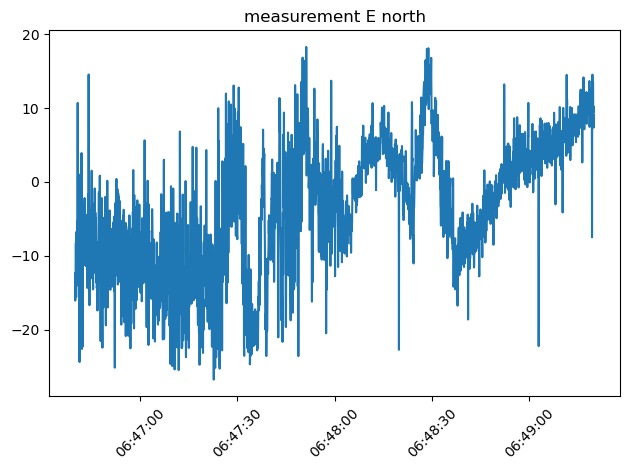

In [35]:
plt.plot(extend_timestamps_e, extend_Ehn)
plt.title("measurement E north")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

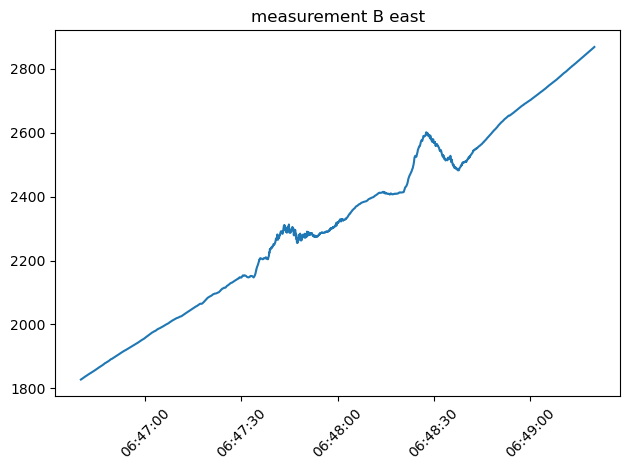

In [36]:
plt.plot(timestamps_b, be)
plt.title("measurement B east")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## move average

In [37]:
def move_average(array,fs:int,window_seconds:int=20, center:bool=True,min_periods: int = None):
    """
    :param array:
    :return:
    """
    window = fs * window_seconds
    assert type(window) == int, "window must be an integer"
    # todo:: use the plot of the later part to verify the 'center', 'min_periods' parameters
    # series_mov_ave = series_.rolling(window=window).mean()
    # series_mov_ave = series_.rolling(window=window, min_periods=min_periods).mean()
    array_series = pd.Series(array)
    array_series_mov_ave = array_series.rolling(window=window, center=center,min_periods=min_periods).mean()  # 'center=True' 得到的结果等于‘结果.mean()=0’
    return array_series_mov_ave.values

In [38]:
fs_e = 16
fs_b = 50

In [39]:
Ehn_mov_ave = move_average(extend_Ehn, fs_e)

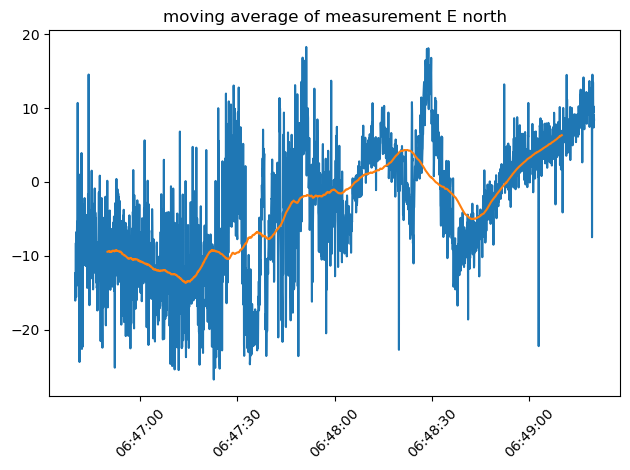

In [40]:
# plt.figure()
plt.plot(extend_timestamps_e, extend_Ehn)
plt.plot(extend_timestamps_e, Ehn_mov_ave)
plt.title("moving average of measurement E north")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# plt.savefig(f'before and after moving average comparison')

In [52]:
be_mov_ave = move_average(be, fs_b, center=False, min_periods=1)

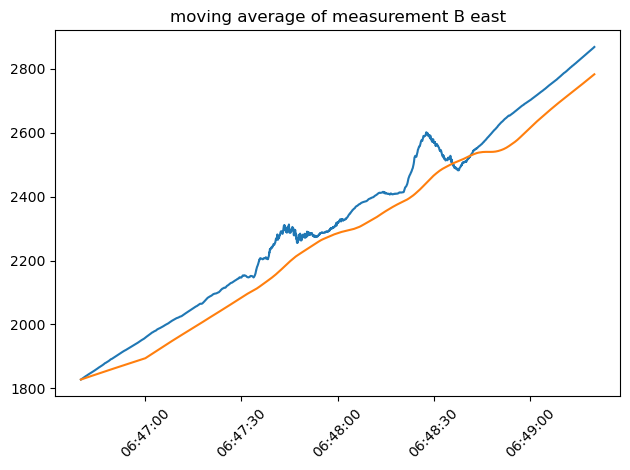

In [53]:
# plt.figure()
plt.plot(timestamps_b, be)
plt.plot(timestamps_b, be_mov_ave)
plt.title("moving average of measurement B east")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# plt.savefig(f'before and after moving average comparison')

#### disturb field

delete the moving average of the field

In [43]:
def transform_time_string_to_datetime64(time_string):
    """
    :param time_string: str. like "20160311T064700".
    :return: np.datetime64[ns]
    """
    # Insert delimiters to make it ISO 8601 compliant
    formatted_string = time_string[:4] + "-" + time_string[4:6] + "-" + time_string[6:8] + "T" + time_string[9:11] + ":" + time_string[11:13] + ":" + time_string[13:]
    # Convert to numpy.datetime64 with nanosecond precision
    return np.datetime64(formatted_string, 'ns')

transform_time_string_to_datetime64(analytical_start_time)

numpy.datetime64('2016-03-11T06:47:00.000000000')

In [44]:
extend_Ehn_disturb = extend_Ehn - Ehn_mov_ave
extend_be_disturb = be - be_mov_ave

In [45]:
mask_e = np.where((extend_timestamps_e >= transform_time_string_to_datetime64(analytical_start_time)) & (extend_timestamps_e <= transform_time_string_to_datetime64(analytical_end_time)))
mask_e

(array([ 320,  321,  322, ..., 2237, 2238, 2239], dtype=int64),)

In [ ]:
timestamps_e =

In [37]:

extend_Ehn_disturb = extend_Ehn_disturb[transform_time_string_to_datetime64(analytical_start_time):transform_time_string_to_datetime64(analytical_end_time)]

TypeError: slice indices must be integers or None or have an __index__ method

# down-resample the MAGx_HR_1B data (50hz)

- 1b 算法文档中提到 vfm 有截止频率大约 9hz？(Swarm Level 1b Processor Algorithms. pdf, page20). so when down-resampling the MAGx_HR_1B magnetic field data to 16hz, don't firstly filter the data?